# Пример отчёта: Ранжирование ресторанов на основе запроса пользователя

---

**Курс:** Проектирование систем машинного обучения  
**Студент:** Овчаров Илья Вячеславович  
**Группа:** М8О-211СВ-24

---

## 1. Введение и постановка задачи

Проектируется система ранжирования ресторанов, которая на основе пользовательского запроса (например, «суши рядом со мной») выдаёт упорядоченный список заведений, учитывая ключевые факторы, с использованием методов Learning-to-Rank (LTR).

Ключевые факторы системы:
- **Релевантность** запроса (соответствие типа кухни, названия, описания);
- **Расстояние** до пользователя;
- **Рейтинг** ресторана (средняя оценка и количество отзывов);
- **Цена** (категория или средний чек).

### Бизнес-цели

Проектируемая система направлена на улучшение следующих ключевых бизнес-метрик:
- **Click-through rate (CTR)** — доля пользователей, кликнувших на один из показанных ресторанов;
- **Conversion rate (CVR)** — доля пользователей, совершивших заказ после просмотра выдачи;
- **Среднее время сессии** — косвенный показатель вовлечённости и удовлетворённости выдачей.

### Требования к системе

Система должна соответствовать следующим нефункциональным требованиям:
- **Задержка (latency)** ответа не должна превышать **469 мс**;
- Поддержка **3 046 433 активных пользователей в день (DAU)**;
- Пиковая нагрузка до **2238 запросов в секунду (RPS)**;
- **Масштабируемость** — возможность горизонтального расширения без изменения архитектуры;
- **Отказоустойчивость** — обеспечение доступности даже при частичных сбоях компонентов.

---

### Часть 1: Формулировка ML-задачи и выбор модели

### 1. Определение ML-задачи

**Формулировка задачи**:  
Задача формулируется как **обучение ранжированию (Learning-to-Rank, LTR)**. Конкретно — **pointwise ранжирование (для соответствия требованиям к задержке)**, где для каждого ресторана предсказывается его релевантность заданному пользовательскому запросу.  
Для построения системы ранжирования ресторанов необходимо понимать, какие данные могут быть получены от пользователей и от самих заведений. Эти данные делятся на **обязательные** (доступные в большинстве случаев) и **опциональные** (доступные не всегда, но потенциально полезные).

#### Данные от пользователя

**Обязательные:**
- Текстовый запрос (например, «суши рядом со мной»);
- Текущее географическое положение (для учёта близости заведений).

**Опциональные:**
- История предыдущих взаимодействий (просмотры, заказы, клики, оценки);
- Предпочтения (например, избранные категории кухни или ценовой диапазон);
- Устройство или контекст использования (мобильное приложение, время суток и т.п.).

#### Данные о ресторанах

**Обязательные:**
- Геолокация (для расчёта расстояния до пользователя);
- Категории кухни (например, итальянская, азиатская, фастфуд);
- Время работы (для фильтрации недоступных заведений);
- Уровень цен ($, $$, $$$) или средний чек;
- Название и краткое описание.

**Опциональные:**
- Полное меню (может использоваться для более тонкого совпадения с запросом);
- Фотографии интерьеров или блюд;
- Агрегированные метрики: общий рейтинг, количество отзывов, частота заказов;
- Данные о наличии акций или текущих скидках.

Понимание структуры и полноты этих данных позволяет не только сформировать информативные признаки для модели, но и определить, как может быть построена целевая переменная (таргет). Для каждой пары (пользовательский запрос, ресторан) вычисляется метка релевантности по следующей иерархии:

#### 1. Явные сигналы доступны  
*(оценка, лайк, явный фидбэк)*  
→ Используется нормализованная оценка (например, 5-звёздочный рейтинг → шкала 0–3):

- **4.5 – 5.0** → **3**  
- **3.5 – 4.4** → **2**  
- **2.5 – 3.4** → **1**  
- **< 2.5** → **0**

#### 2. Явных сигналов нет, но есть неявные сигналы  
*(клик, просмотр >30 с, заказ)*  
→ Назначается релевантность на основе поведения:

- **Заказ или повторный визит** → **3**  
- **Клик + просмотр карточки >30 с** → **2**  
- **Простой клик без дальнейшего взаимодействия** → **1**  
- **Нет взаимодействий** → **0**

#### 3. Нет ни явных, ни неявных сигналов  
*(например, новый пользователь или новый ресторан)*  
→ Используется синтетическая релевантность, основанная на совпадении запроса и атрибутов ресторана:

- **Точное совпадение категории кухни** и **ресторан в радиусе ≤2 км** → **3**  
- **Частичное совпадение** (например, «азиатская» vs «суши») и **расстояние ≤5 км** → **2**  
- **Совпадение только по ключевым словам в названии/описании** **или** **расстояние ≤10 км** → **1**  
- **Нет совпадений** или **ресторан далеко (>10 км)** → **0**

---

### 2. Выбор модели

Рассмотрим две модели, подходящие для pointwise Learning-to-Rank в условиях жёстких требований к задержке (≤469 мс) и высокой нагрузке (2238 RPS):

**Модель 1: Gradient Boosted Decision Trees (GBT) — LightGBM**

- **Преимущества**:
  - Очень высокая скорость инференса (микросекунды на запрос при оптимизации).
  - Отлично работает с табличными признаками (расстояние, рейтинг, цена и т.д.).
  - Встроенная поддержка pointwise LTR (через задачу регрессии или custom objective).
  - Эффективное управление памятью и масштабируемость.
  - Простота развёртывания (не требует GPU).
  - Поддержка категориальных признаков без one-hot кодирования.

- **Недостатки**:
  - Ограниченная способность моделировать сложные нелинейные взаимодействия текст-признаки без ручного feature engineering.
  - Требует предварительной обработки текста (например, через BM25 или предобученные эмбеддинги).

---

**Модель 2: Нейросетевая архитектура (e.g., DNN или Two-Tower Model)**

- **Преимущества**:
  - Может напрямую обрабатывать текст запроса и ресторана через эмбеддинги (например, Sentence-BERT).
  - Лучше моделирует сложные взаимодействия между семантикой запроса и описанием ресторана.
  - Подходит для персонализации при наличии user-эмбеддингов.
  - Гибкость: можно легко расширить архитектуру под новые признаки.

- **Недостатки**:
  - Выше задержка инференса (особенно без оптимизации и GPU).
  - Требует значительных усилий по feature engineering, обучения и настройке.
  - Сложнее деплоить и мониторить в продакшене.
  - Риск over-engineering при наличии в основном структурированных признаков.

---

**Выбранная модель**: **LightGBM**

**Обоснование выбора**:
- Бизнес-сценарий основан на **структурных признаках** (расстояние, рейтинг, цена), где GBT превосходит нейросети по скорости и простоте.
- Требования к задержке (≤469 мс) и высокой RPS (2238) делают **низкую задержку инференса критичной** — LightGBM легко укладывается в бюджет даже на CPU.
- Текстовая релевантность может быть эффективно закодирована через **BM25 или предвычисленные эмбеддинги** (например, Cosine similarity между запросом и названием).
- Простота A/B-тестирования, интерпретируемости и мониторинга в продакшене — важное преимущество для MLOps.

Дальнейшее проектирование будет вестись на основе **LightGBM с pointwise LTR-формулировкой**.

---

### Часть 2: Проектирование архитектуры

### 1. Высокоуровневая архитектура системы

Высокоуровневая архитектура показывает взаимодействие всех основных компонентов системы: от сбора данных о пользователях и ресторанах до обучения модели, её развертывания в режиме инференса и автоматического переобучения на основе пользовательского фидбэка.

**Ключевые компоненты:**

- **Данные о ресторанах (PostgreSQL)**: Реляционная база данных, хранящая метаданные ресторанов — геолокацию, категории кухни, время работы, рейтинг, уровень цен и другую информацию, необходимую для ранжирования.
  
- **Kafka**: Распределённая очередь сообщений, используемая для буферизации потока событий: пользовательских запросов, действий (клики, заказы) и обновлений данных о ресторанах. Обеспечивает надёжную доставку и масштабируемость.

- **S3**: Облачное хранилище, используемое для долгосрочного хранения сырых событий и подготовленных датасетов. Является источником данных для переобучения модели.

- **Retraining trigger**: Компонент, анализирующий накопленные данные в S3 и запускающий процесс переобучения модели при достижении заданных условий (например, накопление достаточного количества новых данных или снижение качества модели).

- **Training pipeline**: Автоматизированный конвейер, выполняющий обучение модели. Включает в себя:
  - **Feature Store** — хранилище признаков, обеспечивающее согласованность между обучением и инференсом;
  - **Labeling Logic** — логика вычисления целевой переменной по единому правилу (на основе явных/неявных сигналов и синтетических правил);
  - **Training Job** — задача обучения модели (например, LightGBM Ranker);
  - **Validations** — проверка качества модели по метрикам (NDCG, AUC);
  - **MLflow** — система управления экспериментами и моделями, регистрирующая параметры, метрики и артефакты;
  - **Model registry** — реестр обученных моделей, управляющий их версиями и жизненным циклом.

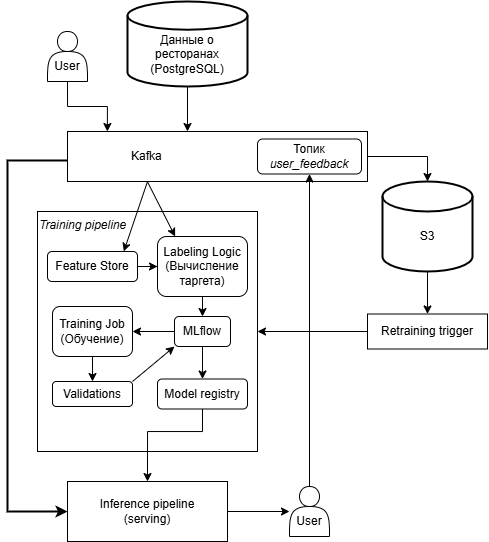

### 2. Архитектура Inference pipeline

Inference pipeline отвечает за обработку пользовательских запросов в реальном времени: от получения запроса до возврата отранжированного списка ресторанов. Система спроектирована для обеспечения низкой задержки, высокой доступности и масштабируемости.

**Ключевые компоненты:**

- **API Gateway (load balancing)**: Точка входа для пользовательских запросов. Распределяет трафик между репликами сервисов, обеспечивает балансировку нагрузки и TLS-терминацию.

- **Redis**: Кэш, используемый для хранения популярных запросов и их результатов. Позволяет ускорить ответ при повторных запросах (например, «суши рядом» в одном районе) и снизить нагрузку на основные сервисы.

- **Candidate retrieval layer**: Слой предварительного отбора кандидатов. Фильтрует рестораны по геолокации, категории кухни и другим ключевым параметрам, сокращая число объектов для ранжирования до 100–200.

- **Feature Engineering Service**: Сервис, формирующий финальный набор признаков для модели. Забирает данные из Feature Store и дополняет их контекстными фичами (расстояние, оставшееся время работы, и т.д.), вычисленными на ходу.

- **LTR Inference Service**: Основной сервис ранжирования, содержащий обученную LTR-модель (LightGBM Ranker). Принимает векторы признаков, вычисляет скоры и возвращает отсортированный список ресторанов.

- **Logging (JSON)**: Компонент, логирующий все запросы и ответы в структурированном JSON-формате для последующего анализа, аудита и обучения.

- **User feedback (Клики)**: Механизм сбора действий пользователя (клики, просмотры, заказы), отправляемых в Kafka для использования в цикле переобучения.

- **Prometheus & Grafana**: Система мониторинга. Prometheus собирает метрики производительности (latency, RPS, error rate), Grafana визуализирует их на дашбордах для оперативного контроля состояния системы.

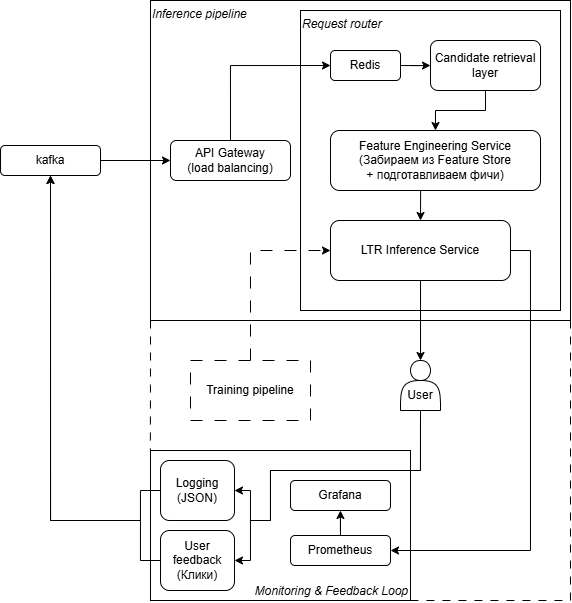

### 3. Архитектура Data Pipeline

Data Pipeline отвечает за сбор, подготовку и формирование обучающего датасета для модели ранжирования. Он обеспечивает согласованность данных между инференсом и обучением, а также воспроизводимость результатов.

**Ключевые компоненты:**

- **Данные о ресторанах (PostgreSQL)**: Источник метаданных о ресторанах — геолокация, категория кухни, рейтинг, время работы. Используется для восстановления состояния ресторана на момент запроса.

- **Kafka**: Центральный брокер событий

- **S3**: Облачное хранилище, куда сырые события из Kafka записываются в партиционированном виде (по дате/часу). Служит источником для последующей обработки и переобучения.

- **Training Data Preparation Pipeline**: Пакетный конвейер, выполняющий подготовку датасета:
  - **Join событий** — объединение запросов, показанных ресторанов, фидбэка и актуального состояния ресторанов (из PostgreSQL);
  - **Feature Extraction** — извлечение статичных фич из PostgreSQL и агрегированных фич из Feature Store;
  - **Labeling** — вычисление целевой переменной (0–3) по единому правилу на основе явных, неявных сигналов и синтетики;
  - **Собираем датасет** — формирование готового набора данных вида `(запрос, ресторан, фичи, таргет)`.

- **S3 (выход)**: Готовый обучающий датасет сохраняется в S3 для использования в Offline Training Pipeline и, при необходимости, логируется в MLflow.

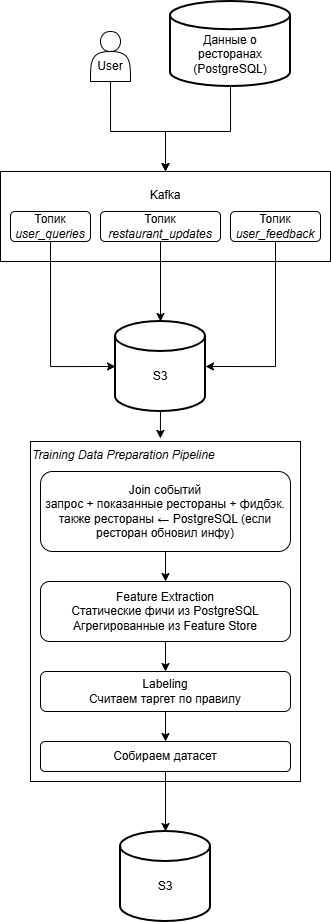

### Часть 3: Расчёты и нефункциональные требования

### 1. Расчёт требований к хранилищу

#### Объём одного события

Пусть каждое событие имеет следующую структуру:

{  

    "user_id": "u123456",  
    "query": "суши рядом со мной",  
    "geo": [55.7558, 37.6176],  
    "timestamp": "2025-12-27T14:30:00Z",  
    "restaurant_id": "r789012",  
    "position_in_list": 3,  
    "event_type": "click",  
    "session_id": "s987654"  
}

- `user_id`, `restaurant_id`, `session_id` — ~20 символов × 3 = **60 байт**  
- `query` — средняя длина 20 символов → **~40 байт** (UTF-8)  
- `geo` — 2 числа с плавающей точкой → 8 байт × 2 = **16 байт**  
- `timestamp` — ISO-строка → **~24 байта**  
- `position_in_list`, `event_type` — **~10 байт**  
- Служебные символы JSON — **~50 байт**

С учётом структуры в формате JSON и запаса на служебные данные, принимаем средний размер одного события за **300 байт**.

#### Поток данных

- Пиковая нагрузка: **2238 RPS** (запросов в секунду);
- Предполагается, что каждый запрос генерирует ответ системы, а 10% запросов — дополнительное событие фидбэка (клик/заказ);
- Общий объём событий:  
  `2238 + 2238 × 0.1 ≈ 2462 события/секунду`.

Объём данных в секунду:  
`2462 × 300 байт ≈ 0.74 МБ/с`.

Объём данных в день:  
`0.74 МБ/с × 3600 × 24 ≈ **63.6 ГБ/день**`.

#### Объём хранилища по компонентам

| Компонент                          | Период хранения | Объём       | Описание |
|-----------------------------------|------------------|-------------|---------|
| **Сырые события (S3 / GCS)**      | 30 дней          | **1.9 ТБ**  | События из Kafka в формате Parquet/JSONL |
| **Обучающие датасеты**            | 30 дней          | **6.4 ТБ**  | Подготовленные датасеты для обучения (213 млн строк/день × ~1 КБ) |
| **Модели и артефакты (MLflow)**   | –                | **10 ГБ**   | Веса моделей, метрики, логи экспериментов |
| **Feature Store**                 | –                | **600 ГБ**  | Агрегированные фичи по пользователям и ресторанам |

#### Итог **≈ 9 ТБ**

### 2. Расчёт требований к пропускной способности

#### Обоснование подхода

Пропускная способность системы определяется её способностью обрабатывать пиковую нагрузку без нарушения требований к задержке (≤ 469 мс).  
Согласно техническому заданию, система должна выдерживать:

**Пиковую нагрузку до 2238 запросов в секунду (RPS)**

#### Производительность одного инстанса

Модели типа LightGBM/XGBoost, используемые в задачах Learning-to-Rank, крайне эффективны на CPU:
- Для списков из 100–200 ресторанов время инференса на запрос составляет **30–100 мс**.
- Это позволяет одному инстансу средней мощности (например, 4 vCPU, 16 ГБ RAM) обрабатывать **200–500 RPS**.

Для **консервативной оценки** (с запасом), принимаем:

**Производительность одного инстанса = 300 RPS**

#### Расчёт количества инстансов

Требуемая общая пропускная способность: **2238 RPS**  
Производительность одного инстанса: **300 RPS**

Количество инстансов = 2238 ÷ 300 ≈ 7.46 → **8 инстансов**

Для обеспечения **отказоустойчивости** (например, при обновлении или сбое одного или двух узлов) добавляем **2 резервных инстанса**.

**Итоговое количество инстансов: 10**

#### Требования к сетевой пропускной способности

#### Входящий трафик
- Средний размер запроса (JSON с `query`, `geo`, `user_id`): **~1 КБ**
- Пиковый RPS: 2238

Входящий трафик = 2238 × 1 КБ = **2.2 МБ/с**

#### Исходящий трафик
- Средний размер ответа (10 ресторанов с атрибутами): **~5 КБ**
- Пиковый RPS: 2238

Исходящий трафик = 2238 × 5 КБ = **11.2 МБ/с**

### 3. Масштабируемость и надёжность

#### Масштабируемость

Система спроектирована для горизонтального масштабирования без изменения архитектуры:

- **Горизонтальное масштабирование сервисов**:  
  Inference Service, Feature Engineering Service, Training Job — все компоненты являются stateless, что позволяет запускать их в нескольких репликах.  
  В Kubernetes можно использовать Horizontal Pod Autoscaler (HPA) для автоматического масштабирования при росте нагрузки (например, по CPU > 70% или RPS).

- **Масштабирование данных**:  
  Kafka и S3 — распределённые системы, легко масштабируются путём добавления брокеров/объектов хранения.  
  Feature Store (на Redis) также масштабируется горизонтально.

- **Масштабирование обучения**:  
  Training Pipeline может быть запущен на кластере Spark или в Airflow с параллельными задачами — это позволяет обучать несколько моделей одновременно или обрабатывать большие объёмы данных.

#### Надёжность (отказоустойчивость)

Система обеспечивает высокую доступность даже при частичных сбоях компонентов:

- **Репликация сервисов**:  
  Все ключевые сервисы (Inference, Feature Engineering, API Gateway) развернуты в нескольких репликах. При падении одной реплики трафик автоматически перенаправляется на здоровые экземпляры через балансировщик.

- **Health Checks (liveness & readiness probes)**:  
  Настроены в Kubernetes для автоматического перезапуска нездоровых подов

- **Резервное копирование**:  
  - Данные о ресторанах (PostgreSQL) → регулярный дамп.  
  - Обучающие датасеты и модели → сохраняются в S3 (с версионированием).

- **Мониторинг**:  
  Prometheus собирает метрики (latency, error rate, RPS, CPU), Grafana визуализирует дашборды.

- **Восстановление после сбоев**:  
  Kubernetes автоматически восстанавливает узлы и поды. Если модель "сломалась" (например, из-за drift), Retraining Trigger запускает переобучение, а старая версия остаётся в Model Registry как fallback.

---

## Вывод

Таким образом, спроектированная система ранжирования ресторанов полностью удовлетворяет заданным нефункциональным требованиям: обеспечивает низкую задержку (≤ 469 мс), масштабируется до 2238 RPS при 3+ млн DAU, обладает отказоустойчивой и воспроизводимой архитектурой, а также поддерживает автоматический цикл обучения и мониторинга. Предложенная MLOps-инфраструктура позволяет надёжно развивать и поддерживать систему в production-среде.